<a href="https://colab.research.google.com/github/siddhi47/streamlit-image-classification/blob/master/model_serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


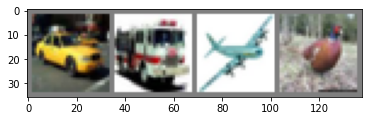

car   truck plane bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.162
[1,  4000] loss: 1.850
[1,  6000] loss: 1.680
[1,  8000] loss: 1.582
[1, 10000] loss: 1.509
[1, 12000] loss: 1.474
[2,  2000] loss: 1.416
[2,  4000] loss: 1.360
[2,  6000] loss: 1.356
[2,  8000] loss: 1.322
[2, 10000] loss: 1.304
[2, 12000] loss: 1.284
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

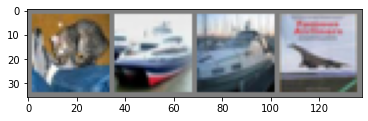

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [ ]:
p = net(images.to(device))

In [ ]:
_, predict = torch.max(p,1)

In [ ]:
predict

tensor([3], device='cuda:0')

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  deer  truck dog   horse


In [ ]:
import flask

In [ ]:
from flask import Flask, request, jsonify

In [ ]:
app = Flask(__name__)

In [ ]:
from PIL import Image

In [ ]:
transform = transforms.Compose(
    [ transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((32,32))])


In [ ]:
del predict

In [ ]:
@app.route('/predicts',methods = ['POST'])
def predicts():
  if request.method == 'POST':
    f = request.files['file']
    f.save('temp.jpg')
    image = Image.open('temp.jpg') 
    tensor_image = transform(image)
    return str(classes[torch.max(net(torch.stack([tensor_image]).to(device)),1)[1]])

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ngrok  authtoken <auth_token>

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask_ngrok import run_with_ngrok
run_with_ngrok(app)

In [ ]:
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://607c-35-247-55-5.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
 * Running on http://607c-35-247-55-5.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Mar/2023 01:05:52] "POST /predicts HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Mar/2023 01:06:22] "POST /predicts HTTP/1.1" 200 -
